
<img src="../../img/ods_stickers.jpg">

## <center>Открытый курс по машинному обучению. Сессия № 2</center> ##
# <center>Индивидуальный проект по анализу данных </center>#
### <center>Автор материала: Кирилл Власов </center> ###



##  Часть 0. Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import sklearn
from sklearn import linear_model,metrics,model_selection, preprocessing
from tqdm import tqdm_notebook 
from matplotlib import pyplot as plt
import geopy as geo
import geopy.distance as dist
import arcgis
from arcgis.gis import GIS
import folium
from folium import plugins
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns

#Отключим предупредения
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##  Часть 1. Описание набора данных и признаков

### Цели и задачи ###
Спрогнозировать кол-во посещений в музеях РФ в 2016 году по историческим данным. Сделать выводы о влиянии различных факторов на посещаемость. 
> Прим.: Известны данные с 2008 по 2016 год, поэтому будем прогнозировать именно 2016, однако, "отрежем" данные за этот год, позже - после некоторых преобразований

### Источник данных ###

Для исследования использованны статистические данные по музеям с официального сайта <a href ="http://opendata.mkrf.ru/opendata/7705851331-stat_museum/">Министерства Культуры России</a>
Данные за последние 9 лет можно скачать в удобном для работы csv формате, однако сайт не позволяет скачивать данные сразу за несколько лет, поэтому на входе получены 9 файлов. Для удобства работы названия признаков заменены на короткие. Итогововый датасет можно скачать <a href ="https://drive.google.com/open?id=1BMKpbFUymeW4f16vc-HoChNxHewjJcXm">тут</a>.

### Признаки ###
#### Целевой ####
- __visitor:__ Число посещений – всего, измеряется в тыс.чел  

#### Объясняющие ####
- __Name:__ Название музея  
- __kopuk:__ КОПУК (код классификатора по учреждениям культуры)
- __adres:__ Адрес  
- __pred_general:__ Число предметов основного фонда на конец года, единиц  
- __pred_second:__ Число предметов научно-вспомогательного фонда на конец года, единиц  
- __pred_elcat:__ Число музейных предметов, внесенных в электронный каталог музея, единиц  
- __ex:__ Число выставок – всего, единиц  
- __workers:__ Численность работников - всего, человек  
- __build:__ Число строений - всего, единиц  


In [3]:
#Соберем DataFrame из нескольких csv файлов. 
for i in range(9):
    data = pd.read_csv("../../data/museum_research/data-" + str(i+1) + "-structure-1.csv",)
    data['year'] = 2008 + i #добавим еще признак, отражающий ГОД, на конец которого представлены данные
    if i == 0:
        df = data
    else:  
        df = pd.concat([df,data],axis=0, ignore_index=True)

In [4]:
print('DataFrame содержит ' + str(df.shape[0]) +' объектов и ' + str(df.shape[1]) + ' признаков. Взглянем на них:')
df.head()

DataFrame содержит 23783 объектов и 11 признаков. Взглянем на них:


,Name,kopuk,adres,pred_general,pred_second,pred_elcat,ex,visitor,workers,build,year
0,"Гос.археологический музей-зап.""Костенки""",114019,"396355 Воронежская обл., Хохольский р-н, с.Кос...",40120,419,0,7,5.6,20,3,2008
1,Аскинский ист.-краеведческий музей,138210,"452880 Респ.Башкортостан, Аскинский р-н, с.Аск...",2893,422,0,23,2.6,2,1,2008
2,Амгинск.муз.ист.гражданск.войны в Якутии,128613,"678600 Респ.Саха(Якутия), Амгинский р-н, с.Амг...",2051,1375,0,13,1.6,10,4,2008
3,"Музей ""Древние курганы Салбыкской степи""",137735,"655100 Респ.Хакасия, Усть-Абаканский р-н, с.Мо...",0,0,0,2,9.8,10,2,2008
4,Саратовский этнографический музей,122015,"410600 г.Саратов, ул.Ульяновская, 26",0,0,0,7,16.4,11,1,2008


В глаза бросается адрес Музея, как кладязь информации. 
Попробуем сразу получить больше информации из признака "Адрес", сгенерируем дополнительно признаки из географических координат:  
- __longitude__: долгота
- __latitude__: широта  
Попутно из геоданных заберем пару категориальных признаков:
- __region__: Название Субъекта
- __okrug__: Название округа
  
Для геокодирования призанов, воспользуемся классом geocode из библиотеки __ArcGis__

In [859]:
gis = GIS()

uni_adress = pd.unique(df['adres']) #выберем уникальные Адреса
lat = {} #сформируем словарь для широты
long = {} #сформируем словарь для долготы
region = {}
okrug = {}

#Пробежимся по нашему списку уникальных адресов
for i in tqdm_notebook(range(uni_adress.shape[0])): 
    geo = arcgis.geocoding.geocode(uni_adress[i], max_locations=1)[0] #получаем ГЕО данные 
    lat[str(uni_adress[i])] = geo['location']['y'] #формируем словари с координатами (x - долгота, y - широта)
    long[str(uni_adress[i])] = geo['location']['x']
    region[str(uni_adress[i])] = geo['attributes']['Region']
    okrug[str(uni_adress[i])] = geo['attributes']['Territory']
    
df['latitude'] = df['adres']
df['longitude'] = df['adres']
df['region'] = df['adres']
df['okrug'] = df['adres']

df['latitude'] = df['latitude'].apply(lambda x: lat[x])
df['longitude'] = df['longitude'].apply(lambda x: long[x])
df['region'] = df['region'].apply(lambda x: region[x])
df['okrug'] = df['okrug'].apply(lambda x: okrug[x])

df.to_csv('../../data/museum_research/data-all-coord.csv',index_label='index') #сохраним данные

> _Вычисления выше, занимают от 30 минут до часа, чтобы не собирать геоданные заного, данные сохранены в файл 'data-all-coord.csv'_

## Пришло время, разделить данные на обучающую и контрольную выборки ##

Напомню, что прогнозировать планируем посещения в 2016-ом году.
>_Но сначала загрузим данные заного, если выше, что-то пошло не так :)_

In [5]:
df = pd.read_csv('../../data/museum_research/data-all-coord.csv',
                 index_col='index') 

df_pred = df[df.year == 2016]
df = df[df.year != 2016]
print('Объектов для исследования: ', df.shape[0],', для прогноза:', df_pred.shape[0])
print('Итоговый датасет содержит: ',df.shape[1], ' признаков, в том числе 1 целевой')

Объектов для исследования:  21146 , для прогноза: 2637
Итоговый датасет содержит:  15  признаков, в том числе 1 целевой


Проводить исследование данных будем, принимая тот факт, что мы вообще не знаем данных за 2016 год, а лишь будем смотреть на нее как на отложенную выборку. 

##  Часть 2. Первичный анализ данных ##
Разобьем признаки на типы и поговорим про каждый из них
- Целевой 
    - visitor
- Категориальные признаки: 
    - kopuk
    - region 
    - okrug
    - year
- Вещественные признаки: 
    - pred_general 
    - pred_second
    - pred_elcat
    - ex
    - workers
    - build
    - latitude
    - longitude
- Текстовые признаки: 
    - Name
    - adres

In [6]:
#Категориальные признаки: 
cat = ['kopuk','region','okrug','year']
#Вещественные признаки:
num = ['pred_general', 'pred_second', 'pred_elcat', 'ex', 'workers',
       'build', 'latitude', 'longitude']
#Текстовые признаки:
txt = ['Name','adres']

### Изучение целевого признака ###
Целевая переменая, вещественное число и наша задача будет сведена к задаче восстановления регрессии, поэтому нам важно, чтобы целевая переменная имела нормальное распределение. 

Построим графики плотности рапределения целевой пременной, а так же сравним распредление с нормальным. 

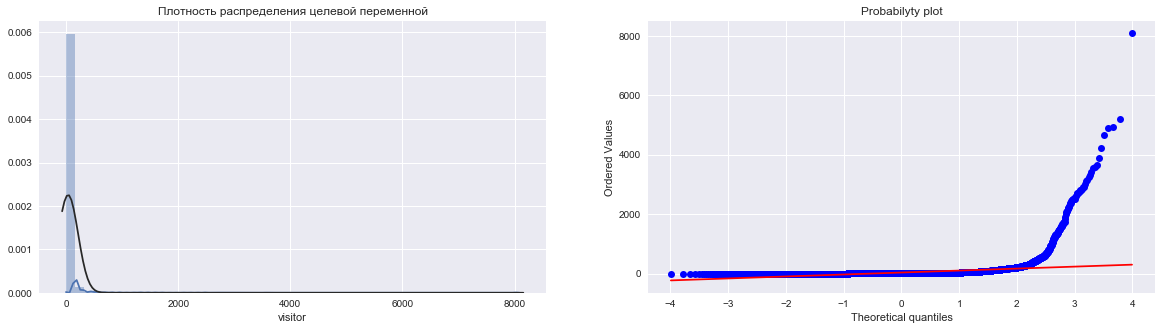

In [7]:
sns.set(rc={"figure.figsize": (20, 5)})
fig = plt.figure()
ax1 = fig.add_subplot(121)
p_x = sns.distplot(df['visitor'], fit=st.norm, kde=True,ax=ax1, bins=50)
ax1.legend()
ax1.set_title('Плотность распределения целевой переменной')
ax2 = fig.add_subplot(122)
prob = st.probplot(df['visitor'], dist=st.norm, plot=ax2)
ax2.set_title('Probabilyty plot')
ax2.legend()
plt.show()

Из графиков становится видно, что распределение не симметрично, скошено и совсем не походит на нормальное распределение, Дополнительно проверим это статистическими тестами с помощью класса stats из библиотеки scipy, но для начала вспомним теорию.
> _Распределение оценивается как предположительно близкое к нормальному, если установлено, что от 50 до 80 % всех значений располагаются в пределах одного стандартного отклонения от среднего арифметического, и коэффициент эксцесса по абсолютной величине не превышает значения равного двум._

> _Распределение считается достоверно нормальным если абсолютная величина показателей асимметрии и эксцесса меньше их ошибок репрезентативности в 3 и более раз._

> _Дополнительно применим тест Шапиро-Уилка_

In [8]:
def norm_testing(vector):
    testA = np.sqrt(6/len(vector))
    testE = 2 * np.sqrt(6/len(vector))
    A = np.abs(np.round(st.skew(vector),decimals=2))
    E = np.abs(np.round(st.kurtosis(vector) ,decimals=2))
    print('Асимметрия: ', A, '. Скошенность больше ошибки репрезентативности в : ',
        np.abs(np.round(st.kurtosis(vector)/testA, decimals=2)) , ' раз.')
    print('Эксцесс: ', E, '. Куртозис больше ошибки репрезентативности в : ',
          np.abs(np.round(st.kurtosis(vector)/testE, decimals=2)) , ' раз.')
    print('Гипотеза о нормальности распределения не отвергается с вероятностью: ', st.shapiro(vector)[1]*100, '%')
    return 

norm_testing(df['visitor'].values)

Асимметрия:  17.9 . Скошенность больше ошибки репрезентативности в :  27222.68  раз.
Эксцесс:  458.56 . Куртозис больше ошибки репрезентативности в :  13611.34  раз.
Гипотеза о нормальности распределения не отвергается с вероятностью:  0.0 %


### Вывод 1: ###
__Распределение не нормально__, повторюсь, что перед нами стоит задача восстановения регресии, то нам очень важно приблизить распределение целевой переменной к нормальному. (См. часть "Предобработка данных")

### Изучение категориальных признаков ###

In [9]:
df[cat].head(3)

,kopuk,region,okrug,year
index,,,,
0,114019,Воронежская область,Центральный федеральный округ,2008
1,138210,Республика Башкортостан,Приволжский федеральный округ,2008
2,128613,Республика Саха (Якутия),Дальневосточный федеральный округ,2008


In [10]:
for i in range(len(cat)):
    print('Признак', cat[i], ' содержит ', len(np.unique(df[cat[i]].fillna(""))), ' уникальных значений')
    
#fillna применён, потому что в признаке okrug есть какое-то пустое значение,
# вызваное следствием ошибки в геокоддировании (См. часть "Предобработка данных")

Признак kopuk  содержит  3023  уникальных значений
Признак region  содержит  88  уникальных значений
Признак okrug  содержит  9  уникальных значений
Признак year  содержит  8  уникальных значений


- признак kopuk, исходя из своей природы, является уникальным ID для каждого музея и имеет место  OneHotEncoding
- признаки region и okrug заданы текстово и перед применением OneHotEncoding необходимо произвести label-кодирование
- Признак year в рамках проекта будем рассматривать как вещественный, тем более, что в на отложенной выборке знаечение 2016 появляется впервые.

In [11]:
#Категориальные признаки: 
cat = ['kopuk','region','okrug']
#Вещественные признаки:
num = ['pred_general', 'pred_second', 'pred_elcat', 'ex', 'workers',
       'build', 'latitude', 'longitude','year']

### Вывод 2: ###
__Проведем OneHotEncoding по всем категориальным признакам, кроме year __

### Изучение вещественных признаков ###

In [12]:
df[num].describe()

,pred_general,pred_second,pred_elcat,ex,workers,build,latitude,longitude,year
count,2.114600e+04,2.114600e+04,2.114600e+04,21146.000000,21146.000000,21146.000000,21146.000000,21146.000000,21146.000000
mean,2.399659e+04,7.642608e+03,9.588523e+03,20.438570,28.796463,3.725480,54.896718,57.516505,2011.578124
std,1.356238e+05,2.906866e+04,7.807555e+04,20.896143,92.581582,21.073906,5.018967,29.922800,2.285214
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.320546,-179.118680,2008.000000
25%,9.720000e+02,2.160000e+02,0.000000e+00,7.000000,4.000000,1.000000,52.715938,38.261893,2010.000000
50%,3.680000e+03,1.272500e+03,0.000000e+00,15.000000,8.000000,1.000000,55.356000,46.987825,2012.000000
75%,1.168850e+04,4.501000e+03,1.060000e+03,27.000000,19.000000,2.000000,57.580555,63.753695,2014.000000
max,4.625946e+06,1.500000e+06,3.335281e+06,397.000000,2598.000000,1059.000000,71.962370,177.694610,2015.000000


### Вывод 3: ###
Вещественные признаки имеют разную размерность, поэтому необходимо произвести их стандартизацию 
### Изучение Текстовых признаков ###

In [13]:
df[txt].head(3)

,Name,adres
index,,
0,"Гос.археологический музей-зап.""Костенки""","396355 Воронежская обл., Хохольский р-н, с.Кос..."
1,Аскинский ист.-краеведческий музей,"452880 Респ.Башкортостан, Аскинский р-н, с.Аск..."
2,Амгинск.муз.ист.гражданск.войны в Якутии,"678600 Респ.Саха(Якутия), Амгинский р-н, с.Амг..."


- Название музея является таким же уникальным ID для каждого музея как kopuk, и будет с ним корреллировать,
- Из признака adres, мы получили достаточно информации на этапе сбора датасета,
В рамках текущего проекта предлагается данне признак не использовать.

Однако, в дальнейшем их можно использовать в качестве источника для порождения дополнительных признаков (см. часть "Выводы")

##  Часть 3. Первичный визуальный анализ данных ##

В рамках проекта решается задача прогнозирования посещений в 2016-ом году, посмотрим, на тенденцию изменения посещений по Годам.

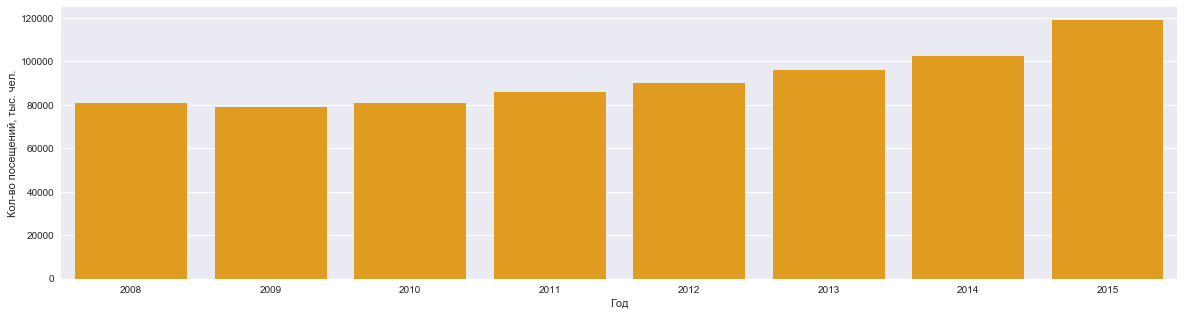

In [14]:
pvt = df.pivot_table(columns=['year'], values='visitor', aggfunc='sum')
plt.figure()
sns.barplot(pvt.columns.values, pvt.values[0], color='Orange', palette=None,)
plt.xlabel('Год')
plt.ylabel('Кол-во посещений, тыс. чел.')
plt.show()

Взглянем, на матрицу корреляции признаков:


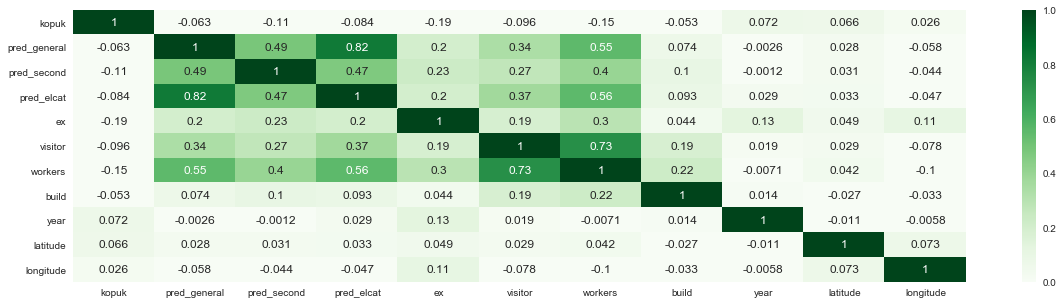

In [15]:
print('Взглянем, на матрицу корреляции признаков:')
sns.set(palette='GnBu_r', rc={"figure.figsize": (20, 5)})
sns.heatmap(df.corr(), vmin=0, vmax=1,annot=True, cmap='Greens',)
plt.show()

### Выводы: ###
- Признак pred_elcat имеет сильную линейную связь (r=0.82) с pred_general, что вполне логично, исходя из природы данных. Возникает риск мультиколлениарности. 
- координаты музея, слабо коррелируют с целевым признаком. 
- целевой признка имеет наибольшую линейную связь (r=0.73) с workers, однако здесь нужно учесть, что скорее всего именно кол-во посещений влияло на кол-во сотрудников. 



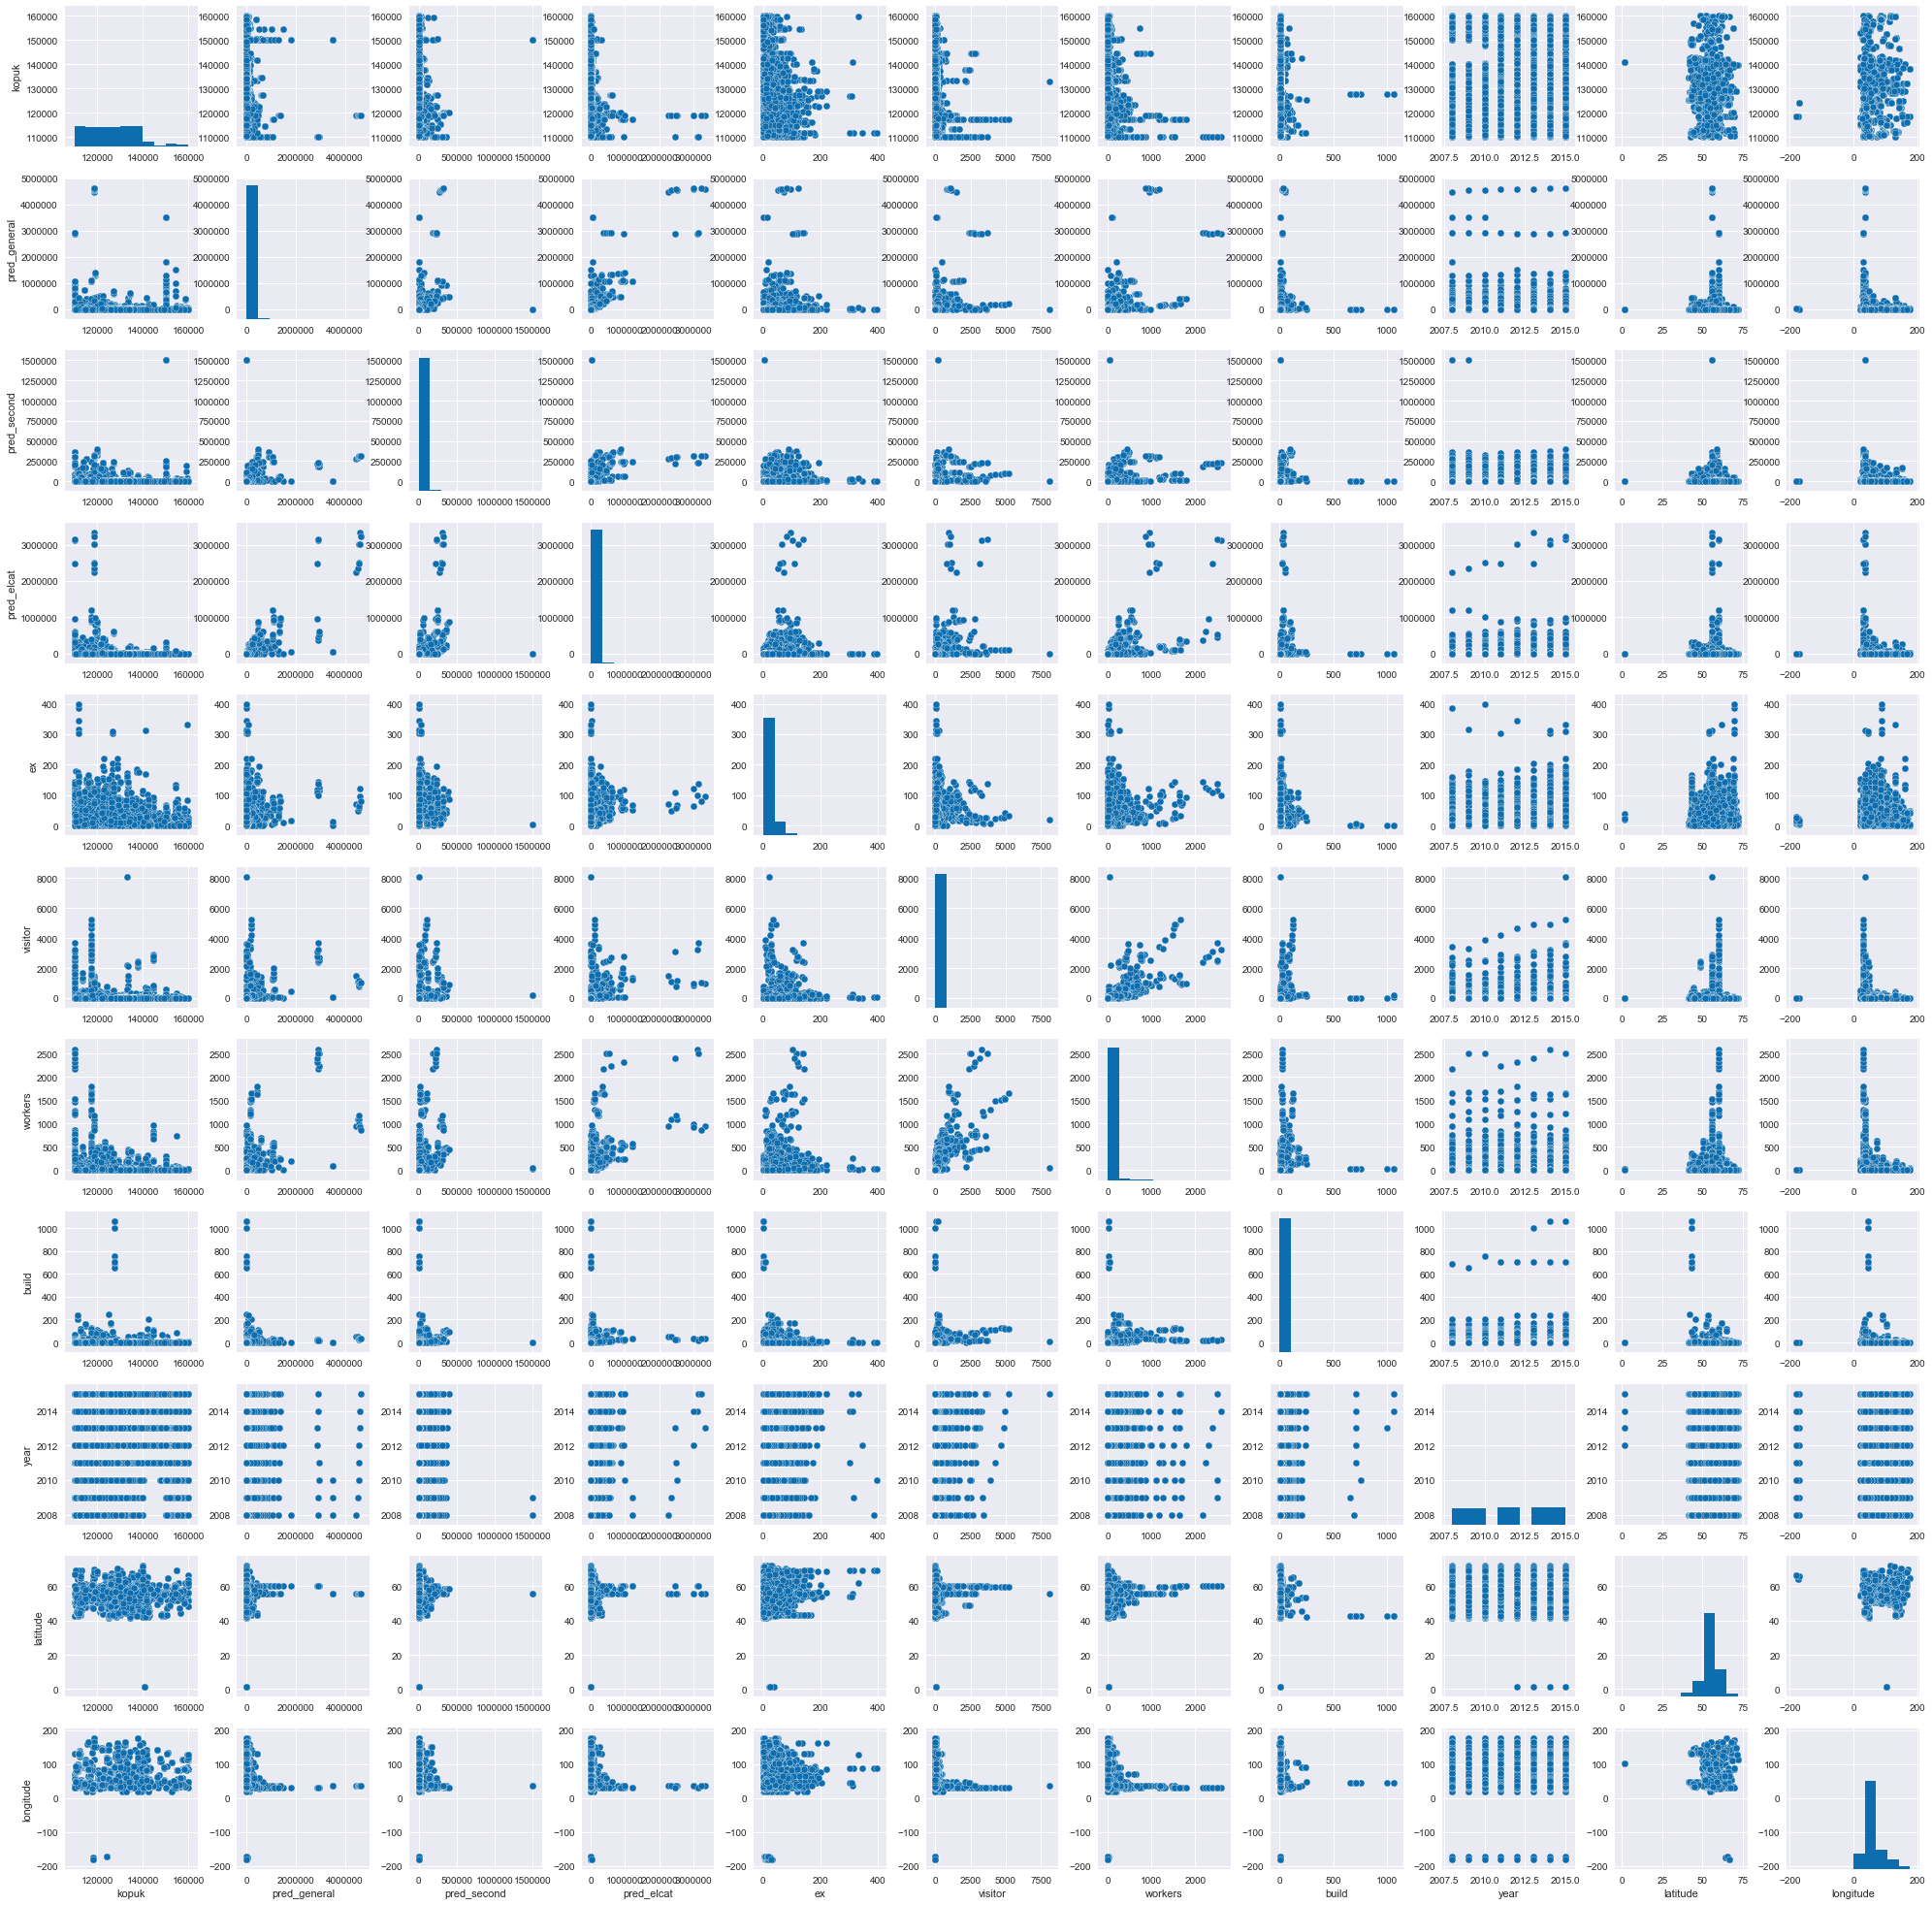

In [16]:
sns.pairplot(df)

Стоит сделать предположение, что координаты, в некоторых строках определены не верно и данные являются выбросами

Попробуем построить HeatMap посещений на карте РФ по координатам с помощью модуля Folium

In [17]:
tunguzka = [60.7308, 101.9744]
folium.Map.choropleth
h_map = folium.Map(location=tunguzka, zoom_start=3,tiles='OpenStreetMap', width='100%', height = 700)

data = [[x[0], x[1],x[2]] for x in np.array(df[df['year'] ==2015][['latitude','longitude','visitor']])]

plugins.HeatMap(data, radius = 12,blur = 9).add_to(h_map)
h_map.render()
#h_map.save('map.html')
h_map

Судя по карте, можно предположить, что кол-во посещений сильно зависит от расстояния до центральных городов, как например Москва и Петербург и может послужить дополнительным признаком (см. часть "Создание новых признаков и описание этого процесса")

##  Часть 4. Закономерности, "инсайты", особенности данных##

### Выбросы, пропуски, ошибки Гео-данных###
Посмотрим, что из себя представляют выбросы на координатах:

In [19]:
print('Всего объектов:', df[df.latitude <= 25]['region'].shape[0],
      ' в регионах:', np.unique(np.unique(df[df.latitude <= 25]['region'])))

print('Всего объектов:', df[df.longitude <= 0]['region'].shape[0],
      ' в регионах:', np.unique(np.unique(df[df.longitude <= 0]['region'])))

Всего объектов: 4  в регионах: ['Singapore']
Всего объектов: 24  в регионах: ['Чукотский автономный округ']


Для Чукотского автономного округа такие координаты являются вполне нормальными, однако, Сингапура в РФ точно нет, судя по Wiki :)  

Посмотрим, что это за музей втесался в наши официальные данные МинКульта:

In [20]:
np.unique(df[df.region == 'Singapore']['Name'])

array(['Музей "Садовое кольцо"'], dtype=object)

Ошибка в гео данных "выскочила" по одному музею, и можно без особого труда восстановить данные (см. часть "Предобработка данных")
Правильные значения (ист. Wiki):
- okrug: 'Центральный федеральный округ'
- latitude: 55.7744
- longitude: 37.6395
- region: 'Москва'   




### Проверка на выбросы по целевому признаку ###
Проверим, что за аномальные скачки были у целевого признака и являются ли они выбросами

In [21]:
un_name = np.unique(df[df.visitor > 3000]['Name']) 
for i in range(len(un_name)):
    print(un_name[i], ' за год посещают в среднем: ', 
          np.round(np.mean(df[df.Name == un_name[i]]['visitor']), decimals=2)
          , 'тыс., а максимум достигал: ',
            np.round(np.max(df[df.Name == un_name[i]]['visitor']), decimals=2), 'тыс.')

Гос.музей-заповедник "Петергоф"  за год посещают в среднем:  4317.4 тыс., а максимум достигал:  5209.6 тыс.
Гос.музей-заповедник "Царское Село"  за год посещают в среднем:  2417.36 тыс., а максимум достигал:  3563.1 тыс.
Гос.музей-памятник "Исаакиевский Собор"  за год посещают в среднем:  2847.86 тыс., а максимум достигал:  3595.2 тыс.
Государственный Эрмитаж  за год посещают в среднем:  2851.11 тыс., а максимум достигал:  3668.0 тыс.
Московское объединение "Музеон"  за год посещают в среднем:  1624.75 тыс., а максимум достигал:  8083.5 тыс.


Так как в выборку попали самые крупные музеи РФ, то смело можно сделать вывод, что данные скачки обусловленны природой данных, а не аномальными выбросами.

##  Часть 5. Выбор метрики##

В задачах регрессии обычно используется среднеквадратичная ошибка или средняя абсолютная ошибка, которые подходят для сравнения двух моделей или для контроля качества во время обучения, но не позволяет сделать выводов о том, насколько хорошо данная модель решает задачу.
Учитывая широкий разброс целевой переменной, и специфику задачи логично в качестве метрики выбрать коэффициент детерминации (r2_score) и посмотреть насколько хорошо модель объясняет данные или же наш прогноз сопоставим по качеству с константным предсказанием.

##  Часть 6. Выбор модели ##

Предлагается использовать линейную модель для восстановления регрессии.  

__Предпосылки: __
- Большое кол-во признаков, с разряженными матрицам
- Хочется интерпретировать коэфициенты для выявления влияния факторов

__Ограничения: __
- Имеем риск получения плохого результата, так как зависимость целевой переменной от признаков нелинейная (Видно из матрицы корреляции)

В качестве линейной модели будет использован __SGDRegressor__:
- Быстро обучается
- Гибко настраивается
- Позволяет использовать регуляризацию

##  Часть 7. Предобработка данных ##


### Исправление ошибок Геокодинга ###


In [22]:
df[df.region == 'Singapore']['okrug'] = 'Центральный федеральный округ'
df[df.region == 'Singapore']['latitude'] = 55.7744
df[df.region == 'Singapore']['longitude'] = 37.6395
df[df.region == 'Singapore']['region'] = 'Москва'

df_pred[df_pred.region == 'Singapore']['okrug'] = 'Центральный федеральный округ'
df_pred[df_pred.region == 'Singapore']['latitude'] = 55.7744
df_pred[df_pred.region == 'Singapore']['longitude'] = 37.6395
df_pred[df_pred.region == 'Singapore']['region'] = 'Москва'

# !!!!!!!!!!!! Не присваиваются значения! Исправь! 
df.dropna(inplace=True)
df_pred.dropna(inplace=True)

### Обработка целевого признака для приведения к нормальному распределению ###
Попробуем для начала просто взять логарифм из целевой переменной

Асимметрия:  0.89 . Скошенность больше ошибки репрезентативности в :  65.39  раз.
Эксцесс:  1.1 . Куртозис больше ошибки репрезентативности в :  32.69  раз.
Гипотеза о нормальности распределения не отвергается с вероятностью:  0.0 %


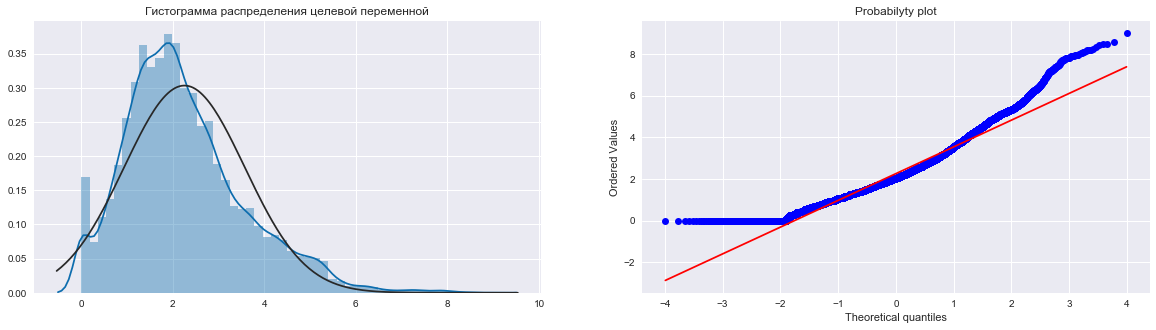

In [23]:
target_modified = np.log((df['visitor'].values)+1)
norm_testing(target_modified) #Используем тест, который использовали ранее

#Построим графики
fig = plt.figure()
ax1 = fig.add_subplot(121)
prob = sns.distplot(target_modified, fit=st.norm, kde=True,ax=ax1)
ax1.set_title('Гистограмма распределения целевой переменной')
ax2 = fig.add_subplot(122)
prob = st.probplot(target_modified, dist=st.norm, plot=ax2)
ax2.set_title('Probabilyty plot')
ax2.legend()
plt.show()

Логарифмирование дало эффект, однако, для достижения большего результата применим Метод Бокса-Кокса, так же из класса stats из библиотеки scipy

Асимметрия:  0.0 . Скошенность больше ошибки репрезентативности в :  0.06  раз.
Эксцесс:  0.0 . Куртозис больше ошибки репрезентативности в :  0.03  раз.
Гипотеза о нормальности распределения не отвергается с вероятностью:  5.283409875709823e-26 %


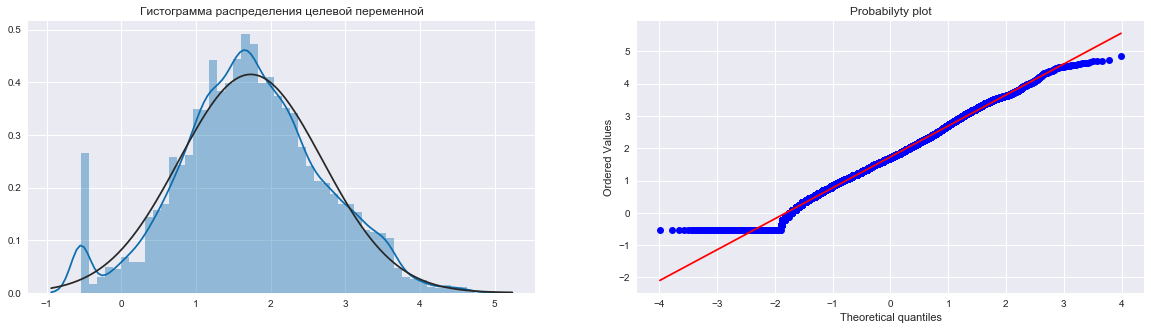

In [24]:
step_boxcox = 0.592
target_modified = (df['visitor']+step_boxcox)
par = st.boxcox(target_modified)
target_modified = par[0]
par_lamb = par[1] #Пригодится, для изменения тестовой выборки
norm_testing(target_modified) #Используем тест, который использовали ранее
df['target'] = target_modified
#Построим графики
fig = plt.figure()
ax1 = fig.add_subplot(121)
prob = sns.distplot(target_modified, fit=st.norm, kde=True,ax=ax1)
ax1.set_title('Гистограмма распределения целевой переменной')
ax2 = fig.add_subplot(122)
prob = st.probplot(target_modified, dist=st.norm, plot=ax2)
ax2.set_title('Probabilyty plot')
ax2.legend()
plt.show()

Картина стала в целом лучше, но Говорить о нормальности распредления нам не позволяет тест Шапиро-Уилка.
> _Прим.: в документации scipy к данному тесту, есть ссылка, что при более чем 5000 объектов p-value может отображаться не корректно._

Применим Трансформацию и к отложенной выборке:

In [25]:
df_pred['target'] = df_pred['visitor']+step_boxcox
df_pred['target'] = st.boxcox(df_pred['target'].values, lmbda=par_lamb)

In [26]:
#Удалим старую целевую переменную
df.drop('visitor', inplace=True, axis=1)
df_pred.drop('visitor', inplace=True, axis=1)

### Проведем OneHotEncoding по всем категориальным признакам ###

Так как уникальные значения категориатных признаков в 2016-ом году встречаются не все, то чтобы ничего не потерять, соединим наши выборки, а потом снова разделим.

In [138]:
df_u = pd.concat([df, df_pred])
df_OHE = pd.concat([df_u.drop('kopuk', 1), pd.get_dummies(df_u['kopuk'],prefix='kopuk') ], axis=1).reindex()
df_OHE = pd.concat([df_OHE.drop('region', 1), pd.get_dummies(df_OHE['region'],prefix='reg') ], axis=1).reindex()
df_OHE = pd.concat([df_OHE.drop('okrug', 1), pd.get_dummies(df_OHE['okrug'],prefix='okr') ], axis=1).reindex()


### Удалим Текстовые фичи ###        

Обоснование удаления приведено в части "Первичный анализ данных"

In [139]:
df_txt = df_OHE.drop(['Name','adres'],axis=1)

### Шкалирование вещественных признаков ###

Шкалирование вещественных признаков и повторное разбиение на тестовую и отложеную выборки будет произведено в части "Кросс-валидация, подбор параметров"


##  Часть 8. Создание новых признаков и описание этого процесса ##

Ранее выдвигалось предположение, о том, что расстояния до Москвы и Санкт-Петербурга могут влиять на кол-во посещений. За основу расчета растояний возьмем Координаты Московского кремля и Дворцовой площади

In [140]:
kremlin = [55.750730, 37.617322] # Координаты Московского кремля
dp_piter = [59.9384, 30.3227] #Координаты Дворцовой площади
dist_to_kremlin = []
dist_to_dp = []

for index, row in tqdm_notebook(df_txt.iterrows()):
    dist_to_kremlin = np.append(dist_to_kremlin, dist.great_circle(( row['latitude'], row['longitude']),(kremlin[0],kremlin[1])).km)
    dist_to_dp = np.append(dist_to_dp, dist.great_circle(( row['latitude'], row['longitude']),(dp_piter[0],dp_piter[1])).km)
    
df_txt['dist_to_kremlin']=dist_to_kremlin
df_txt['dist_to_dp']=dist_to_dp



Exception in thread Thread-55:
Traceback (most recent call last):
  File "/Library/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Рассмотрим облако рассеивания новых переменных и целевой

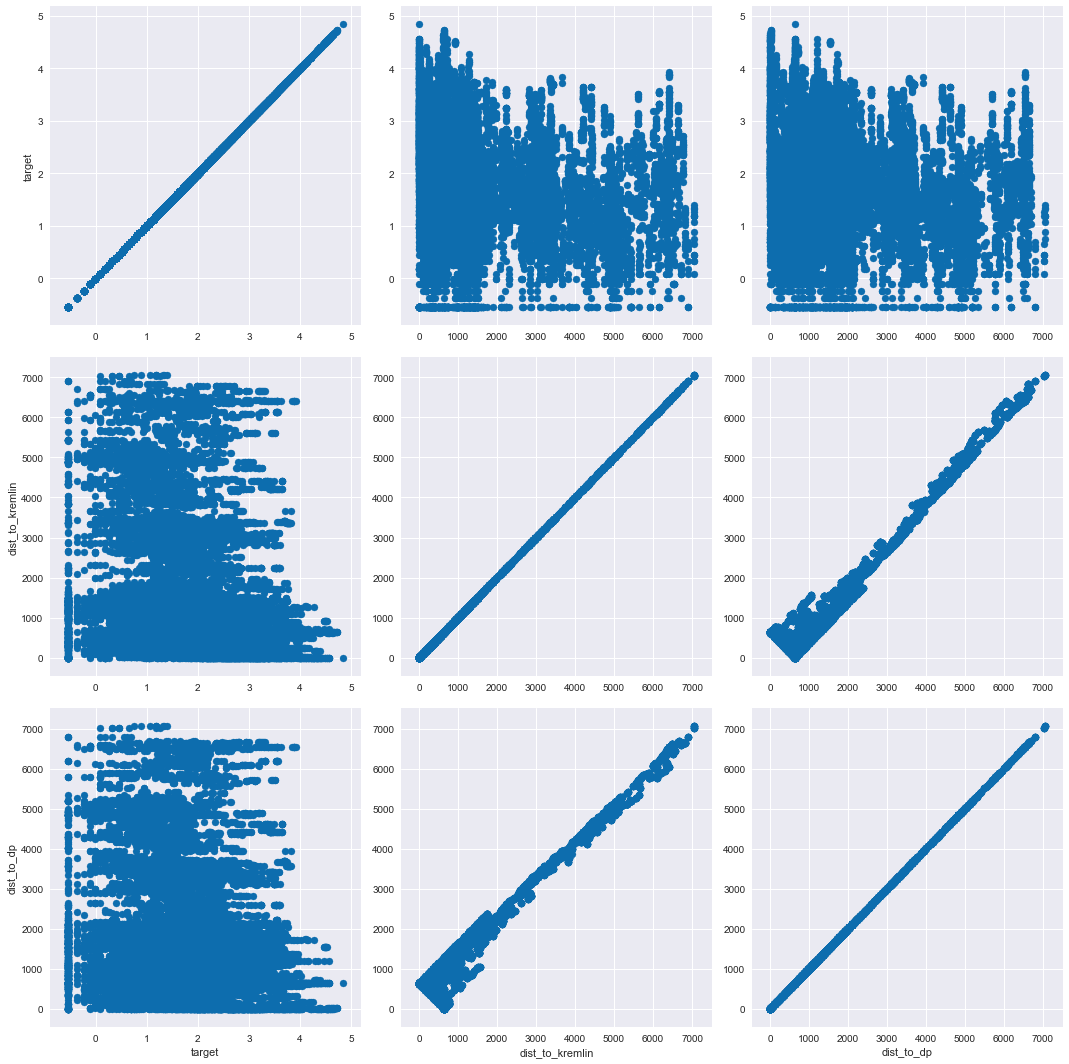

In [141]:
g = sns.PairGrid(df_txt[['target', 'dist_to_kremlin','dist_to_dp']], size=5)
g = g.map(plt.scatter)

Из графика видно, что связь не линейна, чтобы в этом убедиться взглянем на матрицу корреляций:

In [142]:
df_txt[['target', 'dist_to_kremlin','dist_to_dp']].corr()

,target,dist_to_kremlin,dist_to_dp
target,1.000000,-0.129606,-0.138254
dist_to_kremlin,-0.129606,1.000000,0.979646
dist_to_dp,-0.138254,0.979646,1.000000


__Итак:__ Новые признаки не имеют линейной связи, но отрицательные коэфициенты корреляции говорят о наличии обратной зависимости: Чем больше расстояние, тем меньше целевая переменная, что соответсвует нашему изначальному предположению.

## Часть 0. Финальная предобработка данных ##

In [143]:
# Повторно разделим выборку на Обучение и Тест
df_final_pred = df_txt[df_txt.year == 2016]
df_final_train = df_txt[df_txt.year != 2016]
print('Объектов для обучения: ', df_final_train.shape[0],', для прогноза:', df_final_pred.shape[0])
print('Итоговый датасет содержит: ',df_final_train.shape[1], ' признаков, в том числе 1 целевой')

Объектов для обучения:  21126 , для прогноза: 2634
Итоговый датасет содержит:  3161  признаков, в том числе 1 целевой


In [144]:
X_train = df_final_train.drop('target', axis=1).values
y_train = df_final_train['target'].values

X_test = df_final_pred.drop('target', axis=1).values
y_test = df_final_pred['target'].values

#Проведем стандартизацию признаков, о котором говорили в части "Предобработка данных"
scaling = sklearn.preprocessing.StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

## Часть 9. Кросс-валидация и настройка гиперпараметров модели ##

Части "Выбор модели" было описано, что в качестве модели мы будем использовать стохастический градиентный спуск. 
Принимая во внимание, что данные имеют большие выбросы, я буду использовать функцию потерь Губера, её использование позволит уменьшить вклад выбросов и большой квадратичной ошибки, а неточности будут проигнорированы. 


Крос-валидация будет проведена на трех фолдах с перемешиванием.  
Гиперпарметрами для функции будет: 
- Alpha - определяющий порог регуляризации
- Epsilon - порог, при котором становится менее важным получить предсказание точно правильно. Тоесть когда функция потерь изменит свою работу с вида L<sub>2</sub> на L<sub>1</sub>

Обучим класс GridSearchCV у четом сказанного выше.

In [158]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=18)

SGD = linear_model.SGDRegressor(loss='huber', max_iter=100, penalty='l2',
                                random_state=18,learning_rate='optimal')

params = {'alpha': np.linspace(0.01,0.04, num=5),
          'epsilon': np.linspace(0.1,2, num=5)}

grid = model_selection.GridSearchCV(SGD, param_grid=params, scoring='r2', cv=kf, verbose=3)
grid.fit(X_train,y_train)
grid.best_score_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] alpha=0.01, epsilon=0.1 .........................................
[CV]  alpha=0.01, epsilon=0.1, score=0.8497604820025865, total=  17.7s
[CV] alpha=0.01, epsilon=0.1 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s remaining:    0.0s


[CV]  alpha=0.01, epsilon=0.1, score=0.8397951645868753, total=  15.1s
[CV] alpha=0.01, epsilon=0.1 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.0s remaining:    0.0s


[CV]  alpha=0.01, epsilon=0.1, score=0.8528168432602499, total=  16.3s
[CV] alpha=0.01, epsilon=0.575 .......................................
[CV]  alpha=0.01, epsilon=0.575, score=0.8574013803441574, total=  14.4s
[CV] alpha=0.01, epsilon=0.575 .......................................
[CV]  alpha=0.01, epsilon=0.575, score=0.8476282074860582, total=  16.2s
[CV] alpha=0.01, epsilon=0.575 .......................................
[CV]  alpha=0.01, epsilon=0.575, score=0.8610263863409255, total=  15.8s
[CV] alpha=0.01, epsilon=1.05 ........................................
[CV]  alpha=0.01, epsilon=1.05, score=0.8610056111555419, total=  14.7s
[CV] alpha=0.01, epsilon=1.05 ........................................
[CV]  alpha=0.01, epsilon=1.05, score=0.8491006897149028, total=  15.3s
[CV] alpha=0.01, epsilon=1.05 ........................................
[CV]  alpha=0.01, epsilon=1.05, score=0.8641796920114498, total=  16.7s
[CV] alpha=0.01, epsilon=1.525 .....................................

[CV]  alpha=0.0325, epsilon=2.0, score=0.8645372229876283, total=  16.2s
[CV] alpha=0.04, epsilon=0.1 .........................................
[CV]  alpha=0.04, epsilon=0.1, score=0.8543684184473497, total=  15.8s
[CV] alpha=0.04, epsilon=0.1 .........................................
[CV]  alpha=0.04, epsilon=0.1, score=0.8352677098634576, total=  16.2s
[CV] alpha=0.04, epsilon=0.1 .........................................
[CV]  alpha=0.04, epsilon=0.1, score=0.8410606267546201, total=  14.3s
[CV] alpha=0.04, epsilon=0.575 .......................................
[CV]  alpha=0.04, epsilon=0.575, score=0.8599489676952561, total=  14.3s
[CV] alpha=0.04, epsilon=0.575 .......................................
[CV]  alpha=0.04, epsilon=0.575, score=0.8502234303550189, total=  14.7s
[CV] alpha=0.04, epsilon=0.575 .......................................
[CV]  alpha=0.04, epsilon=0.575, score=0.8624593445199858, total=  18.2s
[CV] alpha=0.04, epsilon=1.05 .......................................

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 19.9min finished


0.86062660885051134

In [160]:
grid.best_estimator_

SGDRegressor(alpha=0.040000000000000001, average=False,
       epsilon=1.5249999999999999, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='huber', max_iter=100,
       n_iter=None, penalty='l2', power_t=0.25, random_state=18,
       shuffle=True, tol=None, verbose=0, warm_start=False)

На кросвалидации R<sup>2</sup> - составил 0.86, при параметрах:  
- alpha = 0.04  
- epsilon = 1.525

Учитывая, что коэффициент детерминации выше 80%, можно говорить о хорошем качестве модели

## Часть 10. Построение кривых валидации и обучения ##

In [169]:
alphas = np.linspace(0.01,0.04, num=5)
val_train, val_test = model_selection.validation_curve(SGD, X_train, y_train, param_name='alpha',
                                                       param_range=alphas, cv=kf,
                                       scoring='r2')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


In [170]:
train_sizes = np.linspace(0.05, 1, 10)
N_train, tr_train, tr_test = model_selection.learning_curve(SGD,
                                                  X_train, y_train, train_sizes=train_sizes, cv=kf,
                                                  scoring='r2')

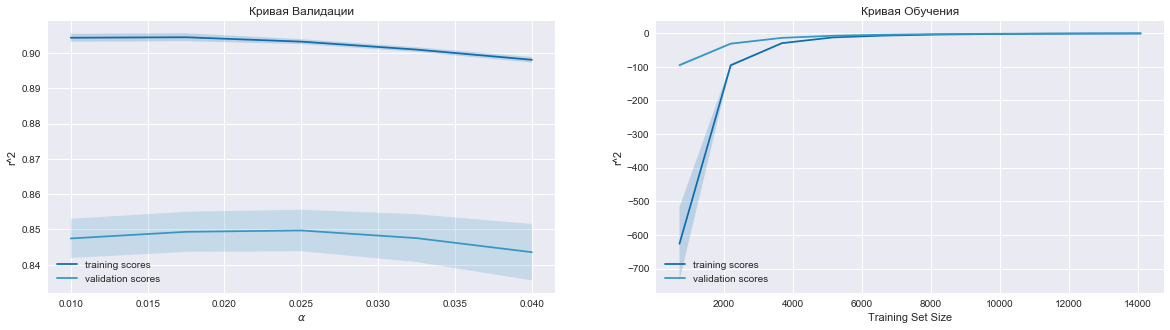

In [195]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)
ax1.set_title('Кривая Валидации')
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('r^2')
plt.legend();


ax2 = fig.add_subplot(122)
ax2.set_title('Кривая Обучения')
plot_with_err(N_train, tr_train, label='training scores')
plot_with_err(N_train, tr_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('r^2')
plt.legend()

Валидационная кривая:
- Так кривые валидации близко друг к другу и их значение близко к 1, то можно говорить об отсутствии переобучения или недообучения. 

Кривая обучения:
- Так как кривые сошлись друг к другу, добавление новых данных ничего не изменит.

## Часть 11. Прогноз для тестовой выборки ##

Спрогнозируем колличество посещений в музея в 2016 году по результатам модели и расчитаем кофициент детерминации для Тестовой выборки:

In [196]:
np.round(metrics.r2_score(y_test, grid.predict(X_test)), decimals=10)

0.82388628129999997

R<sub>2</sub> Для тестовой выборки соотносится с показателем достигнутым на кросс-валидации. 
Можно сделать вывод о том, что модель имеет хорошее качество.  
Посмотрим, какие факторы максимально влияют на целевую переменую:

In [243]:
df_coef = pd.DataFrame({ 'name': df_final_train.drop('target', axis=1).columns, 'value': grid.best_estimator_.coef_ })

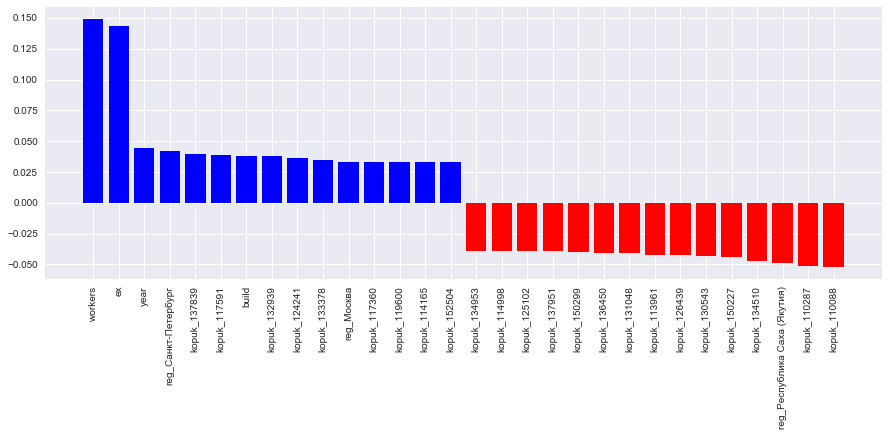

In [266]:
n_top_features = 15
coef_plot = pd.concat([df_coef.sort_values(by='value', ascending=False).head(n_top_features),
                        df_coef.sort_values(by='value', ascending=False).tail(n_top_features)], axis=0)

interesting_coefficients = coef_plot['value']
feature_names = coef_plot['name']

plt.figure(figsize=(15, 5))
colors = ["red" if c < 0 else "blue" for c in interesting_coefficients]
plt.bar(np.arange(1, 2 * n_top_features+1), interesting_coefficients, color=colors)
plt.xticks(np.arange(1, 2 * n_top_features+1), feature_names, rotation=90, ha="center")
plt.show()

##  Часть 12. Выводы ##

Создана модель, которая имеет хорошую обобщающую способность. 
Ценность модели заключается в том, что ее можно использовать для прогнозирования кол-ва посетителей в музеях. На основании полученных данных можно оптимизировать затраты. 

Кроме того, можно выделять факторы, которые максимально влияют на посещаемость музея

В части путей улучшения, можно использовать следующие направления:
- Порождение дополнительных фич из названия музея, например его категорию (Археологический, Исторический, Краеведческий) или оценку (отзывы поситителей).
- Порождатьть дополнительные фичи на основании геоданных из Адреса.
- Для повышения интерпритируемости, возможно Смещение фич на +1 Год для прогноза, так как датасет содержить данные на конец года, но формально они соответствуют данным на начало года